In [100]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import Delaunay
import gc
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def formar_triangulos(points, n):
    # Formar triângulos
    triangles = []
    for i in range(n - 1):
        for j in range(n - 1):
            index_p = i * n + j
            # Triângulo inferior direito
            triangles.append([points[index_p], points[index_p+n], points[index_p+n+1]])
            # Triângulo superior esquerdo
            triangles.append([points[index_p], points[index_p+1], points[index_p+n+1]])
    return triangles

def Matriz_adjacencia(points, n, triangles):

    # Construir a matriz de adjacência
    adj_matrix = np.zeros((n**2, n**2), dtype=int)
    point_index = {point: idx for idx, point in enumerate(points)}

    for triangle in triangles:
        for i in range(3):
            for j in range(i + 1, 3):
                p1 = point_index[triangle[i]]
                p2 = point_index[triangle[j]]
                adj_matrix[p1, p2] = 1
                adj_matrix[p2, p1] = 1

    # Preencher a diagonal principal com 1s
    np.fill_diagonal(adj_matrix, 1)

    # Plotar o gráfico com a malha quadriculada
    fig, ax = plt.subplots(figsize = (2*n,2*n))
    cax = ax.matshow(adj_matrix, cmap='gray_r')

    # Configurar ticks
    ticks = np.arange(n**2)
    ax.set_xticks(np.arange(-0.5, n**2, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n**2, 1), minor=True)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    tick_labels = np.arange(1, n**2 + 1)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)


    # Configurar grade com espessura reduzida
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)

    # Esconder ticks principais
    ax.tick_params(which='major', bottom=False, left=False)

    plt.title('Matriz de Adjacência com Malha Quadriculada')
    plt.show()
    return triangles, adj_matrix

def plot_mesh(points, triangles, n, title):
    num_vertices = len(points)
    num_triangles = len(triangles)
    plt.figure()

    for idx, triangle in enumerate(triangles):
        t_points = np.array(triangle)
        plt.fill(t_points[:, 0], t_points[:, 1], edgecolor='k', fill=False)
        centroid = np.mean(t_points, axis=0)
        plt.text(centroid[0], centroid[1], str(idx+1), color='blue', fontsize=12, ha='center')

    for idx, point in enumerate(points):
        plt.scatter(point[1], point[0], color='r')
        plt.text(point[1], point[0], str(idx+1), color='green', fontsize=12, ha='right', va='bottom')

    plt.title(f"{title}\nVertices: {num_vertices}, Triangles: {num_triangles}")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

def area_of_triangle(p1, p2, p3):
    return 0.5 * abs(p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1]))

def b_matrix(p1, p2, p3, A):
    b = (1 / (2 * A)) * np.array([
        [p2[1] - p3[1], p3[1] - p1[1], p1[1] - p2[1]],
        [p3[0] - p2[0], p1[0] - p3[0], p2[0] - p1[0]]
    ])
    return b

def assemble_system(triangles, points):
    n = len(points)
    K = np.zeros((n, n))
    F = np.zeros(n)
    k_matrix = np.array([[1, 0], [0, 1]])  # Identity matrix as k

    for triangle in triangles:
        p1, p2, p3 = triangle
        indices = [points.index(p1), points.index(p2), points.index(p3)]
        A = area_of_triangle(p1, p2, p3)
        b = b_matrix(p1, p2, p3, A) # matriz de rigidez local
        k_local = A * (b.T @ k_matrix @ b)
        for i in range(3):
            for j in range(3):
                K[indices[i], indices[j]] += k_local[i, j]
        f_local = A / 3 * np.array([1, 1, 1])  # Assuming f(x,y) = 1 for simplicity
        for i in range(3):
            F[indices[i]] += f_local[i]

    # Apply boundary conditions (u = 0 at boundaries)
    for i in range(n):
        if points[i][0] == 1 or points[i][0] == n or points[i][1] == 1 or points[i][1] == n:
            K[i, :] = 0
            K[:, i] = 0
            K[i, i] = 1
            F[i] = 0

    return K, F

def solver_sistema(K, F):
    u = np.linalg.solve(K, F)
    return u

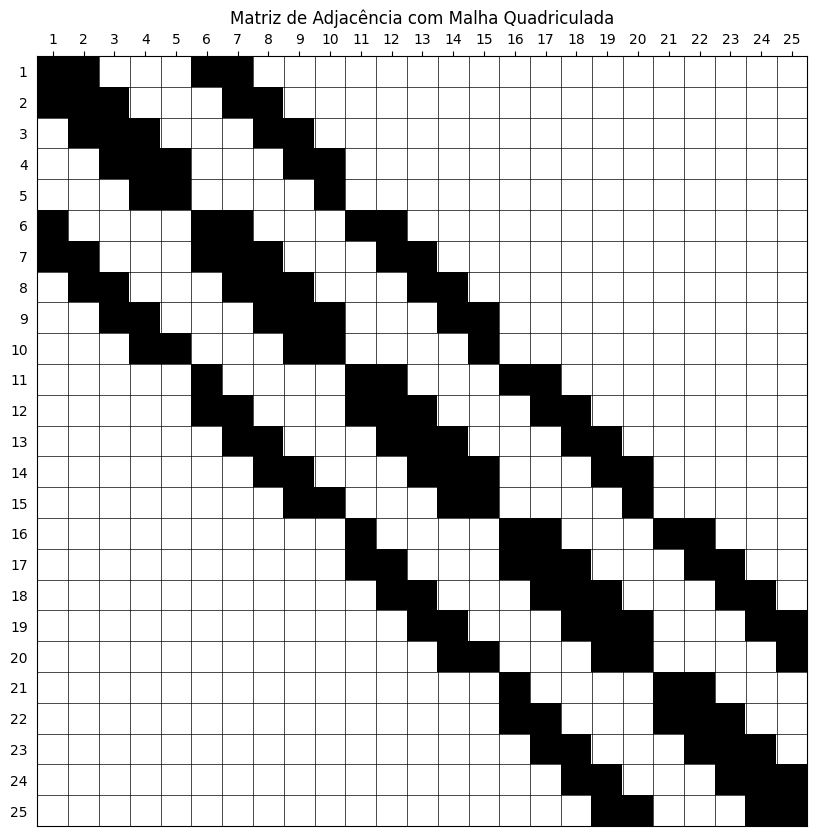

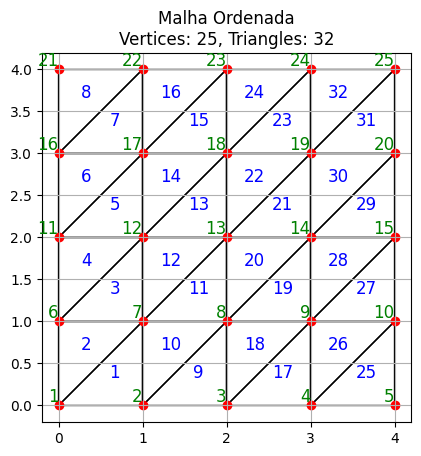

45839

In [101]:
def malha_ordenada(n):
    # Criar uma matriz nxn com n^2 pontos
    points = [(i, j) for i in range(n) for j in range(n)]
    triangles = formar_triangulos(points, n)
    adj_matrix = Matriz_adjacencia(points,n, triangles)
    plot_mesh(points, triangles, n, 'Malha Ordenada')
    return points, triangles
x = malha_ordenada(5)
del x
gc.collect()

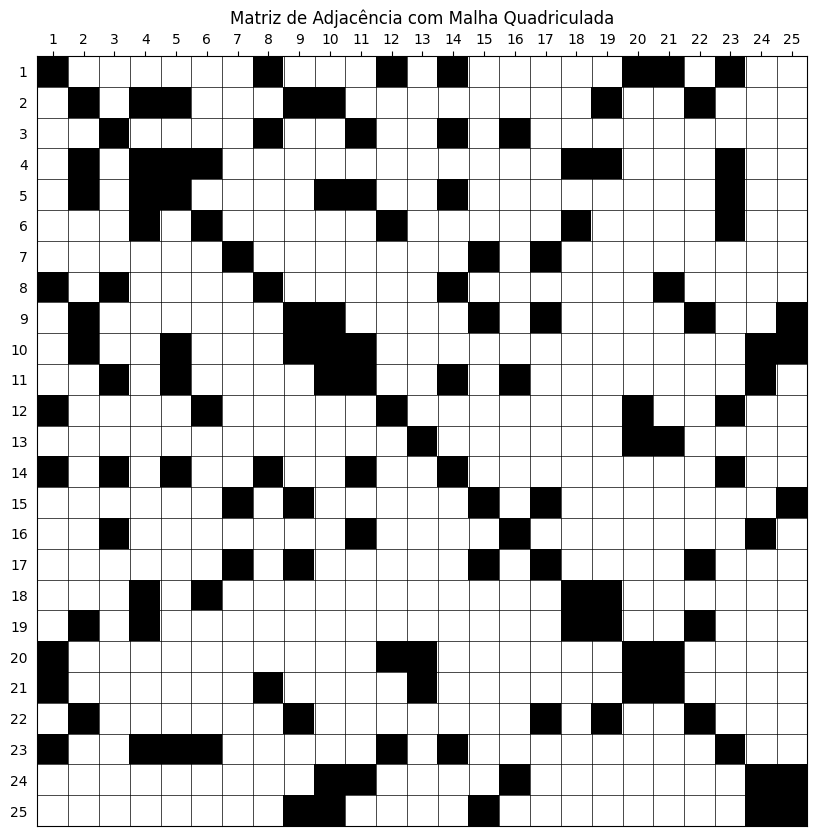

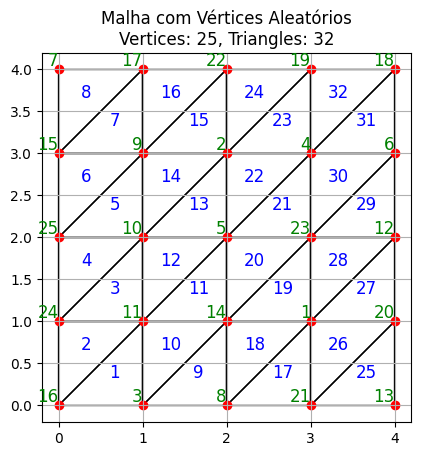

In [102]:
def malha_ver_aleatoria(n):
    # Criar uma matriz nxn com n^2 pontos
    points = [(i, j) for i in range(n) for j in range(n)]
    triangles = formar_triangulos(points, n)

    # Shuffle points without altering triangle connectivity
    shuffled_points = points[:]
    random.shuffle(shuffled_points)

    adj_matrix = Matriz_adjacencia(shuffled_points, n, triangles)
    plot_mesh(shuffled_points, triangles, n, 'Malha com Vértices Aleatórios')

malha_ver_aleatoria(5)


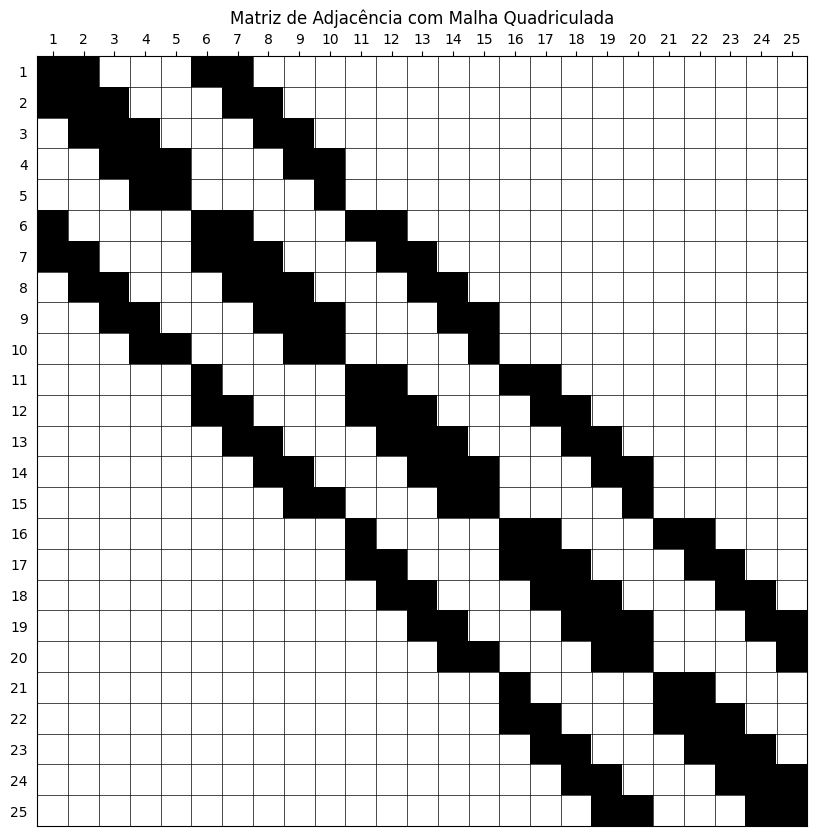

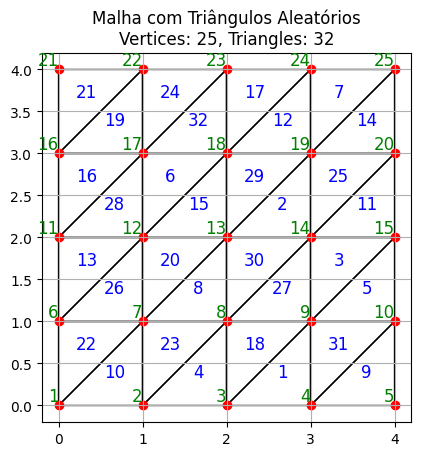

In [103]:
def malha_triang_aleatoria(n):
    # Criar uma matriz nxn com n^2 pontos
    points = [(i, j) for i in range(n) for j in range(n)]
    triangles = formar_triangulos(points, n)


    # Shuffle triangles
    random.shuffle(triangles)

    adj_matrix = Matriz_adjacencia(points, n, triangles)
    plot_mesh(points, triangles, n, 'Malha com Triângulos Aleatórios')
malha_triang_aleatoria(5)


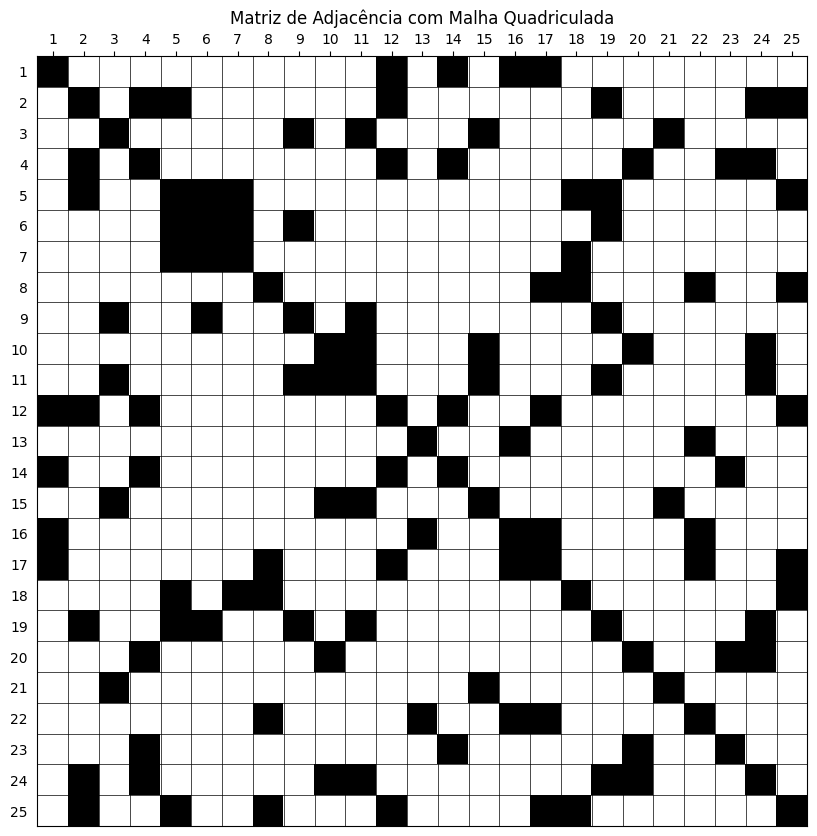

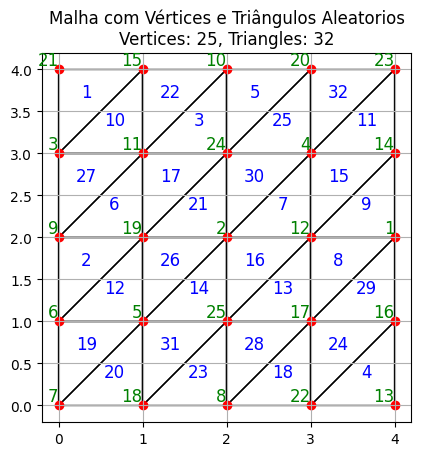

In [104]:
def malha_full_aleatoria(n):
    # Criar uma matriz nxn com n^2 pontos
    points = [(i, j) for i in range(n) for j in range(n)]
    triangles = formar_triangulos(points, n)

    # Shuffle points without altering triangle connectivity
    shuffled_points = points[:]
    random.shuffle(shuffled_points)
    random.shuffle(triangles)

    adj_matrix = Matriz_adjacencia(shuffled_points, n, triangles)
    plot_mesh(shuffled_points, triangles, n, 'Malha com Vértices e Triângulos Aleatorios')
malha_full_aleatoria(5)

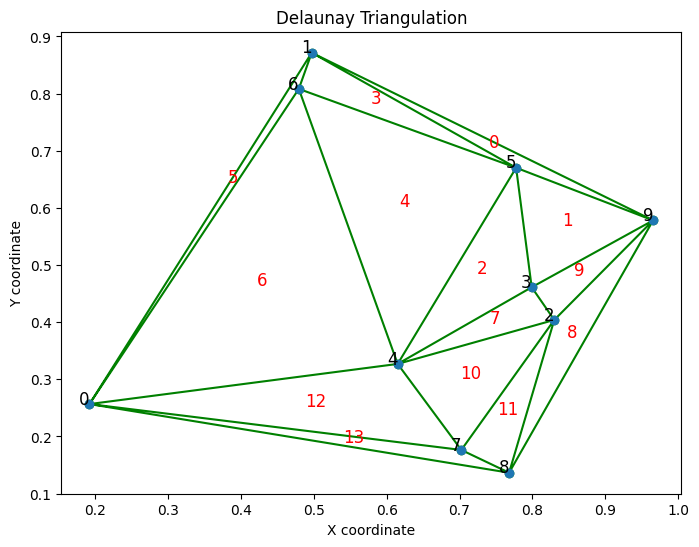

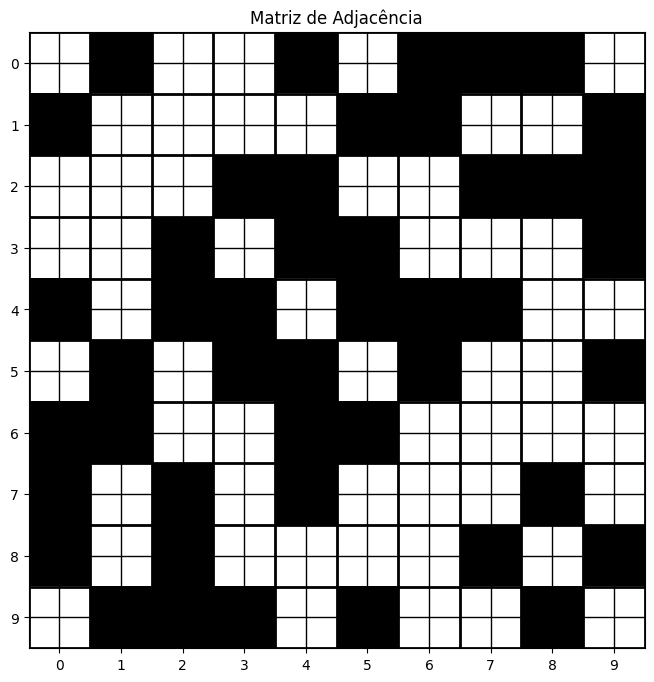

109558

In [115]:
def plot_mesh_delaunay(points, triangles, n, title):
    plt.figure(figsize=(8, 6))
    plt.triplot([p[0] for p in points], [p[1] for p in points], triangles, 'go-')
    plt.plot([p[0] for p in points], [p[1] for p in points], 'o')

    for i, point in enumerate(points):
        plt.text(point[0], point[1], f'{i}', fontsize=12, ha='right')

    for i, simplex in enumerate(triangles):
        centroid = np.mean([points[v] for v in simplex], axis=0)
        plt.text(centroid[0], centroid[1], f'{i}', fontsize=12, ha='center', color='red')

    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title(title)
    plt.show()

def Matriz_adjacencia_delaunay(points, n, triangles):
    adjacency_matrix = np.zeros((n, n))
    for triangle in triangles:
        for i in range(len(triangle)):
            for j in range(i + 1, len(triangle)):
                adjacency_matrix[triangle[i], triangle[j]] = 1
                adjacency_matrix[triangle[j], triangle[i]] = 1

    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='Greys', interpolation='none')
    plt.title('Matriz de Adjacência')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.grid(which='both', color='black', linestyle='-', linewidth=1)

    # Adjust tick marks and grid lines
    plt.gca().set_xticks(np.arange(-.5, n, 1), minor=True)
    plt.gca().set_yticks(np.arange(-.5, n, 1), minor=True)
    plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.gca().tick_params(which='minor', size=0)
    plt.show()

def delaunay_triangulation(n):
    points = [(random.random(), random.random()) for _ in range(n)]
    points_array = np.array(points)
    delaunay = Delaunay(points_array)
    triangles_array = points_array[delaunay.simplices]

    # Convert triangles to hashable type
    triangles = tuple(tuple(map(tuple, triangle)) for triangle in triangles_array)

    plot_mesh_delaunay(points, delaunay.simplices, len(points), 'Delaunay Triangulation')
    Matriz_adjacencia_delaunay(points, len(points), delaunay.simplices)

    return points, triangles

x = delaunay_triangulation(10)
del x
gc.collect()

In [106]:
def Matriz_adjacencia(points, n, triangles):

    # Construir a matriz de adjacência
    adj_matrix = np.zeros((n**2, n**2), dtype=int)
    point_index = {point: idx for idx, point in enumerate(points)}

    for triangle in triangles:
        for i in range(3):
            for j in range(i + 1, 3):
                p1 = point_index[triangle[i]]
                p2 = point_index[triangle[j]]
                adj_matrix[p1, p2] = 1
                adj_matrix[p2, p1] = 1

    # Preencher a diagonal principal com 1s
    np.fill_diagonal(adj_matrix, 1)

    # Plotar o gráfico com a malha quadriculada
    fig, ax = plt.subplots(figsize = (2*n,2*n))
    cax = ax.matshow(adj_matrix, cmap='gray_r')

    # Configurar ticks
    ticks = np.arange(n**2)
    ax.set_xticks(np.arange(-0.5, n**2, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n**2, 1), minor=True)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    tick_labels = np.arange(1, n**2 + 1)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)


    # Configurar grade com espessura reduzida
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)

    # Esconder ticks principais
    ax.tick_params(which='major', bottom=False, left=False)

    plt.title('Matriz de Adjacência com Malha Quadriculada')
    plt.show()
    return triangles, adj_matrix

def plot_mesh(points, triangles, n, title):
    num_vertices = len(points)
    num_triangles = len(triangles)
    plt.figure()

    for idx, triangle in enumerate(triangles):
        t_points = np.array(triangle)
        plt.fill(t_points[:, 0], t_points[:, 1], edgecolor='k', fill=False)
        centroid = np.mean(t_points, axis=0)
        plt.text(centroid[0], centroid[1], str(idx+1), color='blue', fontsize=12, ha='center')

    for idx, point in enumerate(points):
        plt.scatter(point[1], point[0], color='r')
        plt.text(point[1], point[0], str(idx+1), color='green', fontsize=12, ha='right', va='bottom')

    plt.title(f"{title}\nVertices: {num_vertices}, Triangles: {num_triangles}")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

In [107]:
def generate_triangles(n):
    points = [(i, j) for i in range(n) for j in range(n)]
    triangles = formar_triangulos(points, n)
    return triangles, points

# Exemplo de uso
n = 5
triangles, points = generate_triangles(n)
K, F = assemble_system(triangles, points)
u = solver_sistema(K, F)
print("Solução u nos pontos da grade:")
print(u)
print("\nMatriz de Adjacência com valores reais (matriz de rigidez K):")
print(K)

Solução u nos pontos da grade:
[0.33333333 0.         0.35897436 0.43589744 0.38461538 0.
 0.         0.         0.         0.         0.35897436 0.
 0.96153846 1.42307692 1.56410256 0.43589744 0.         1.42307692
 2.16666667 2.41025641 0.38461538 0.         1.56410256 2.41025641
 2.74358974]

Matriz de Adjacência com valores reais (matriz de rigidez K):
[[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   2.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  2.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

<ipython-input-114-fa136df50a24>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_values))  # Adjust colormap as needed


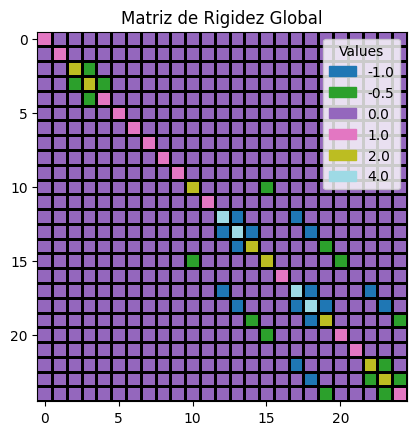

In [114]:
#PLOT 1

import matplotlib.pyplot as plt
import numpy as np
from math import pi
def plot_matrix_gradiente(matrix, label="None"):
    # Get unique values from the matrix
    unique_values = np.unique(matrix)

    # Create a colormap with a specific color for each unique value
    colors = plt.cm.get_cmap('tab20', len(unique_values))  # Adjust colormap as needed
    cmap = {val: colors(i) for i, val in enumerate(unique_values)}

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Map matrix values to colors
    colored_matrix = [[cmap[val] for val in row] for row in matrix]

    # Display the colored matrix as an image
    ax.imshow(colored_matrix, interpolation='none')

    # Draw grid lines between each cell
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            ax.axhline(i+0.5, color='black', lw=1)
            ax.axvline(j+0.5, color='black', lw=1)

    # Create a legend for the colormap
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=cmap[val]) for val in unique_values]
    ax.legend(legend_handles, unique_values, title='Values')

    if label != "None":
        plt.title(label)

    # Show the plot
    plt.show()


plot_matrix_gradiente(K, label = "Matriz de Rigidez Global")

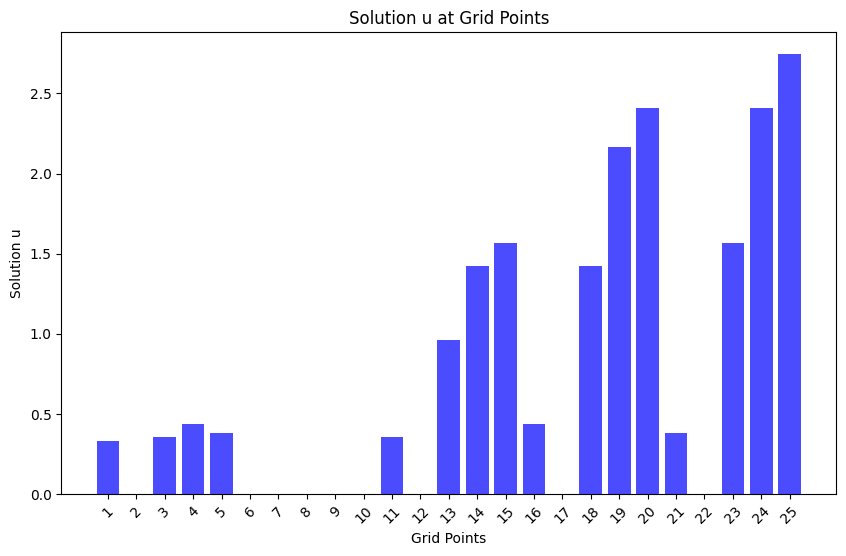

In [109]:
#PLOT 2

def plot_solution(u):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(u)), u, color='b', alpha=0.7)
    plt.xlabel('Grid Points')
    plt.ylabel('Solution u')
    plt.xticks(range(len(u)), [str(p) for p in np.arange(1, len(u)+1)], rotation=45)
    plt.title('Solution u at Grid Points')
    plt.show()
plot_solution(u)